### Analysing current trends on job market by websraping offers from website pracuj.pl
This project is a result of teamwork, I mostly focused on webscraping and preparing the final dataframes, besides languages

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
link_main = "https://www.pracuj.pl/praca/warszawa;wp?rd=30&cc=5002001%2C5032001%2C5003%2C5008%2C5016001%2C5015001&et=1%2C3%2C17"

In [3]:
### Numer ostatniej strony w formacie int


page = requests.get(link_main)
soup = BeautifulSoup(page.content, 'html.parser')
last_page = soup.find_all(class_="listing_ssub1c9 core_pk4iags size-body core_t1rst47b") #Klasa z numerem ostatniej strony

last_page = str(last_page[0]) #Zmiana z listy zawierającej pojedynczy string na string                      

# Uzyskanie samego numeru strony
last_page = last_page.replace('<p class="listing_ssub1c9 core_pk4iags size-body core_t1rst47b"><span class="listing_p1qog568">z</span><span data-test="top-pagination-max-page-number">', '')
last_page = last_page.replace('</span></p>', '')

# Zmiana na format liczbowy
last_page = int(last_page)

In [4]:
### Pozyskanie dataframe z linkami do wszystkich interesujących nas ofert


results = []

# Dla pierwszej strony:
page = requests.get(link_main)
soup = BeautifulSoup(page.content, 'html.parser')
data = soup.find_all(class_="core_n194fgoq")
for x in data: # Zmiana data z bs4.element.resultset na list
    results.append(str(x))


# Dla wszystkich kolejnych stron:
for i in range(2, ostatnia_strona+1):
    page = requests.get(link_main + "&pn=" + str(i))
    soup = BeautifulSoup(page.content, 'html.parser')
    data = soup.find_all(class_="core_n194fgoq")
    for x in data: # Zmiana data z bs4.element.resultset na list
        results.append(str(x))


# Zmiana listy results na dataframe df
df = pd.DataFrame([results])

# Doprowadzenie do czystej postaci
df = df.transpose() #Transpozycja
df.columns=["Link"] #Nazwa kolumny
df = df[df["Link"].str.contains('link-offer')==True] #Pokazywanie tylko pól z linkami do ofert pracy (wyrzucenie tych z linkami do firmy itd)
df = df.reset_index(drop=True) #Reset indeksu

# Usunięcie zbędnych elementów, tak aby pozostał sam link do oferty
df['Link'] = df['Link'].str.replace('"></a>', '', regex=True)
df['Link'] = df['Link'].str.replace('<a class="core_n194fgoq" data-test="link-offer" href="', '', regex=True)

# Usunięcie duplikatów w linkach
df.drop_duplicates(subset="Link")

# Dodanie kolejnych kolumn
df["Technologie"] = ""
df["Obowiązki"] = ""
df["Wymagania"] = ""

In [5]:
### Przyporządkowanie obowiązków i wymagań dla każdej oferty
# Przetworzenie tej komórki zajmuje dosyć długo, do kilku minut, z uwagi na konieczność przeszukania każdego z linku
# Zależy od prędkości internetu

x = 0
for link in df["Link"]:
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    data = soup.find_all(class_="offer-viewIPoRwg") #Klasa, którą mają wszystkie interesujące nas elementy strony
    
    # Podział data na obowiązki i wymagania oraz pozbycie się nagłówków
    obowiązki = ""
    wymagania = ""
    technologie = ""
    for cls in ['offer-viewchej5g', 'offer-viewfkAkeG', 'offer-viewU0gxPf']: #Lista możliwych class oznaczających pola "wymagania" itd. Na stronie możliwe są różne formaty ogłoszeń, (każde pole może mieć inne) stąd kilka class
        if 'data-scroll-id="technologies-1"' in str(data): #Jeśli oferta zawiera zakładkę "technologie"
            technologie = technologie + str(data[0].find_all(class_=cls))
            obowiązki = obowiązki + str(data[1].find_all(class_=cls))
            wymagania = wymagania + str(data[2].find_all(class_=cls))
        else: # Jeśli zawiera tylko "obowiązki" i "wymagania"
            obowiązki = obowiązki + str(data[0].find_all(class_=cls))
            wymagania = wymagania + str(data[1].find_all(class_=cls))
        
    # Doprowadzenie do czystej postaci 
    for sub_str in ['<p class="offer-viewchej5g" data-test="one-column-list-itemParagraph">', '<p class="offer-viewfkAkeG">', '</p>', '[', ']', ',,']:
        obowiązki = obowiązki.replace(sub_str, "")  
    for sub_str in ['<p class="offer-viewchej5g" data-test="one-column-list-itemParagraph">', '<p class="offer-viewfkAkeG">', '</p>', '[', ']', ',,']:
        wymagania = wymagania.replace(sub_str, "")
    for sub_str in ['<p class="offer-viewU0gxPf" data-test="text-technology-name">', '</p>', '[', ']', ',,']:
        technologie = technologie.replace(sub_str, "")
    
    # Dodanie nowych wierszy do dataframe
    df["Technologie"][x] = technologie
    df["Obowiązki"][x] = obowiązki
    df["Wymagania"][x] = wymagania
    x = x+1


In [6]:
# Ustawienia dotyczące wyśietlanych wierszy
pd.set_option('display.max_rows', 10)

In [7]:
### Najczęściej powtarzające się słowa
# Użycie tego było konieczne do przeprowadzenia wstępnej analizy i wytypowania poszukiwanych słów kluczowych do dalszej analizy


pd.Series(' '.join(df['Wymagania']).lower().split()).value_counts()[:200]

w               925
i               738
znajomość       693
na              342
pracy           329
               ... 
year             18
terminowość,     18
(mile            18
excel),          18
powierzone       18
Name: count, Length: 200, dtype: int64

In [8]:
### Tworzenie listy wszystkich technologii z kolumny "technologie"

all_technologies = []
for entry in df['Technologie']:
    if entry != '':
        technologies = entry.split(', ')
        all_technologies.extend(technologies)


technologies_count = pd.Series(all_technologies).value_counts()

In [9]:
### Tworzenie listy poszukiwanych przez nas technologii w kolumnie "wymagania"


# Lista warunków, których wystąpienia chcemy policzyć
warunki = ['SQL', 'Python', 'JavaScript', 'Java', 'Git', 'T-SQL', 'Jira', 'AWS', 'SAS', 'MatLab', 'Maxima', 'Office',
    'Linux', 'C#', 'Oracle', 'PowerBI', 'Selenium', 'Excel', 'APEX', 'Docker', 'SAP', 'HTML', 'CSS', ' R ', 'VBA', 'Azure',
    'NumPy', 'Pandas', 'ELK', 'scikit-learn', 'C++', 'MongoDB', 'Confluence', 'Jenkins', 'Redis', 'PostgreSQL', '.NET', 'Mulesoft', 'PHP']

# Słownik do przechowywania liczby wystąpień każdego warunku
liczba_wystapien = {warunek: 0 for warunek in warunki}

# Funkcja licząca wystąpienia warunków w tekście i aktualizująca liczbę wystąpień w słowniku
def policz_wystapienia(wyrazenie, warunki):
    slowa = wyrazenie.split()  # Podział wypowiedzi na słowa
    for slowo in slowa:
        slowo = " " + slowo + " "
        for warunek in warunki:
            if warunek.lower() in slowo.lower():  # Sprawdzenie czy warunek występuje w słowie (ignorowanie wielkości liter)
                liczba_wystapien[warunek] += 1

# Zastosowanie funkcji do kolumny 'Wymagania'
df['Wymagania'].apply(lambda x: policz_wystapienia(x, warunki))

display(liczba_wystapien)

{'SQL': 58,
 'Python': 14,
 'JavaScript': 8,
 'Java': 17,
 'Git': 16,
 'T-SQL': 4,
 'Jira': 6,
 'AWS': 7,
 'SAS': 6,
 'MatLab': 0,
 'Maxima': 0,
 'Office': 181,
 'Linux': 7,
 'C#': 7,
 'Oracle': 9,
 'PowerBI': 2,
 'Selenium': 8,
 'Excel': 235,
 'APEX': 1,
 'Docker': 5,
 'SAP': 31,
 'HTML': 3,
 'CSS': 1,
 ' R ': 1,
 'VBA': 12,
 'Azure': 8,
 'NumPy': 3,
 'Pandas': 3,
 'ELK': 2,
 'scikit-learn': 3,
 'C++': 4,
 'MongoDB': 1,
 'Confluence': 3,
 'Jenkins': 3,
 'Redis': 1,
 'PostgreSQL': 3,
 '.NET': 6,
 'Mulesoft': 0,
 'PHP': 1}

In [10]:
### Wykres technologie


# Konwertowanie słownika na obiekt pd.Series
wystapienia_series = pd.Series(liczba_wystapien)

# Sortowanie danych od największej do najmniejszej liczby wystąpień
sorted_data = wystapienia_series.sort_values(ascending=False)

# Tworzenie wykresu
plt.figure(figsize=(12, 8))

# Wybór pastelowych kolorów
pastel_colors = plt.cm.Paired(range(len(sorted_data)))

# Wykres słupkowy z pastelowym fioletowym odcieniem, obramowaniem i tylko dla 15 najwyższych wyników
sorted_data[:15].plot(kind='bar', color=pastel_colors, edgecolor='black')

# Tytuł i oznaczenia osi
plt.title('Liczba wystąpień poszczególnych technologii w ofertach',
         fontsize=24)
plt.xlabel('Technologie')
plt.ylabel('Liczba wystąpień')

# Obrót etykiet dla lepszej czytelności
plt.xticks(rotation=45, ha='right')

# Zapisanie wykresu
plt.savefig('Wykres_technologie.png', transparent=True)

# Pokaż wykres
plt.tight_layout()
plt.show()

In [11]:
### Wyszukanie języków


# Lista umiejętności do wyszukania
umiejetnosci = ['ang', 'english', 'german', 'niemiec', 'hiszp', 'spanish', 'norweski', 'norwegian', 'czeski', 'czech', 'francuski', 'french', 'rosyjski', 'russian', 'ukraiński', 'ukrainian', 'włoski', 'italian', 'japoński', 'japanese', 'chiński', 'chinese']  

# Słownik do przechowywania liczby wystąpień każdej umiejętności

liczba_umiejetnosci = {umiejetnosc: 0 for umiejetnosc in umiejetnosci}

# Funkcja licząca wystąpienia umiejętności w tekście i aktualizująca liczbę wystąpień w słownikach
def policz_umiejetnosci(wyrazenie, umiejetnosci):
    slowa = wyrazenie.lower().split()  # Podział wypowiedzi na słowa i zamiana na małe litery
    for slowo in slowa:
        for umiejetnosc in umiejetnosci:
            if umiejetnosc in slowo:
                liczba_umiejetnosci[umiejetnosc] += 1

# Zastosowanie funkcji do kolumny 'Wymagania'
df['Wymagania'].apply(lambda x: policz_umiejetnosci(x, umiejetnosci))

print("Liczba wystąpień umiejętności:")
print(liczba_umiejetnosci)

Liczba wystąpień umiejętności:
{'ang': 317, 'english': 70, 'german': 17, 'niemiec': 16, 'hiszp': 4, 'spanish': 3, 'norweski': 1, 'norwegian': 0, 'czeski': 0, 'czech': 3, 'francuski': 3, 'french': 8, 'rosyjski': 1, 'russian': 0, 'ukraiński': 1, 'ukrainian': 1, 'włoski': 0, 'italian': 3, 'japoński': 0, 'japanese': 0, 'chiński': 0, 'chinese': 0}


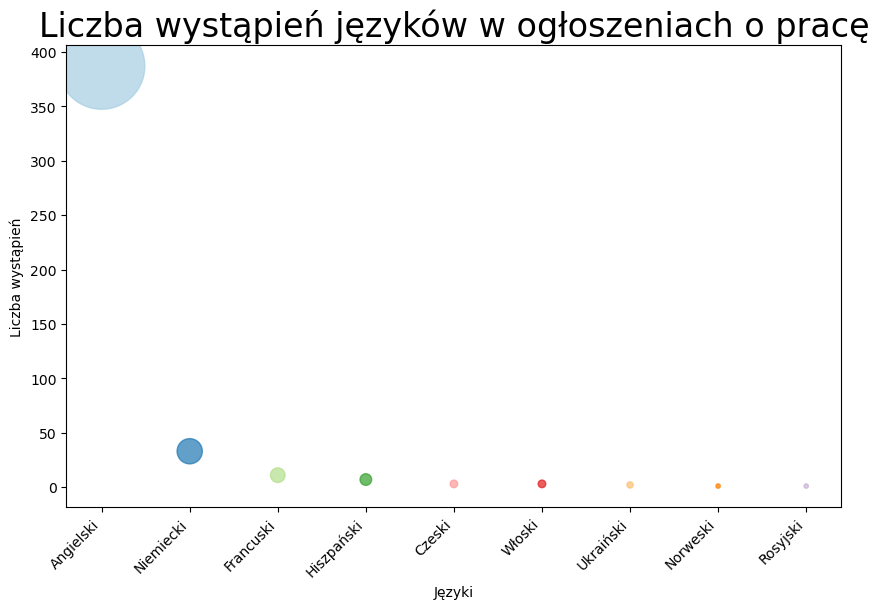

In [12]:
### Wykres języki


# Połączenie liczby języków z wersji polskiej i angielskiej
liczba_umiejetnosci['Angielski'] = liczba_umiejetnosci.get('ang', 0) + liczba_umiejetnosci.get('english', 0)
liczba_umiejetnosci['Niemiecki'] = liczba_umiejetnosci.get('niemiec', 0) + liczba_umiejetnosci.get('german', 0)
liczba_umiejetnosci['Hiszpański'] = liczba_umiejetnosci.get('hiszp', 0) + liczba_umiejetnosci.get('spanish', 0)
liczba_umiejetnosci['Norweski'] = liczba_umiejetnosci.get('norweski', 0) + liczba_umiejetnosci.get('norwegian',0)
liczba_umiejetnosci['Czeski'] = liczba_umiejetnosci.get('czeski', 0) + liczba_umiejetnosci.get('czech',0)
liczba_umiejetnosci['Francuski'] = liczba_umiejetnosci.get('francuski', 0) + liczba_umiejetnosci.get('french',0)
liczba_umiejetnosci['Rosyjski'] = liczba_umiejetnosci.get('rosyjski', 0) + liczba_umiejetnosci.get('russian',0)
liczba_umiejetnosci['Ukraiński'] = liczba_umiejetnosci.get('ukraiński', 0) + liczba_umiejetnosci.get('ukrainian',0)
liczba_umiejetnosci['Włoski'] = liczba_umiejetnosci.get('włoski', 0) + liczba_umiejetnosci.get('italian',0)
liczba_umiejetnosci['Japoński'] = liczba_umiejetnosci.get('japoński', 0) + liczba_umiejetnosci.get('japanese',0)                                                         
liczba_umiejetnosci['Chiński'] = liczba_umiejetnosci.get('chiński', 0) + liczba_umiejetnosci.get('chinese',0)

del liczba_umiejetnosci['english']
del liczba_umiejetnosci['ang']
del liczba_umiejetnosci['niemiec']
del liczba_umiejetnosci['german']
del liczba_umiejetnosci['hiszp']
del liczba_umiejetnosci['spanish']
del liczba_umiejetnosci['norweski']
del liczba_umiejetnosci['norwegian']
del liczba_umiejetnosci['czeski']
del liczba_umiejetnosci['czech']     
del liczba_umiejetnosci['francuski']
del liczba_umiejetnosci['french']
del liczba_umiejetnosci['rosyjski']
del liczba_umiejetnosci['russian']
del liczba_umiejetnosci['ukraiński']
del liczba_umiejetnosci['ukrainian']
del liczba_umiejetnosci['włoski']
del liczba_umiejetnosci['italian']
del liczba_umiejetnosci['japoński']
del liczba_umiejetnosci['japanese']
del liczba_umiejetnosci['chiński']
del liczba_umiejetnosci['chinese']


# Usunięcie języków z ilością wystąpień równą zero
liczba_umiejetnosci = {k: v for k, v in liczba_umiejetnosci.items() if v != 0}

# Sortowanie danych malejąco
sorted_umiejetnosci = dict(sorted(liczba_umiejetnosci.items(), key=lambda item: item[1], reverse=True))

# Tworzenie wykresu kropkowego
plt.figure(figsize=(10, 6))

# Dane dla wykresu kropkowego
x = list(sorted_umiejetnosci.keys())
y = list(sorted_umiejetnosci.values())

# Wykres kropkowy
plt.scatter(x, y, s=[i*10 for i in y], color=plt.cm.Paired(range(len(x))), alpha=0.7)

# Tytuł
plt.title('Liczba wystąpień języków w ogłoszeniach o pracę',
         fontsize=24)

# Oś X - języki
plt.xlabel('Języki')

# Oś Y - liczba wystąpień
plt.ylabel('Liczba wystąpień')

# Obrót etykiet dla lepszej czytelności
plt.xticks(rotation=45, ha='right')

# Zapisanie wykresu
plt.savefig('Wykres_języki.png', transparent=True)

# Pokaż wykres
plt.show()

Liczba wystąpień umiejętności miękkich:
{'analityczn': 123, 'samodzieln': 100, 'komunika': 149, 'zaangażowan': 59, 'skrupulatn': 58, 'otwart': 46, 'dokładn': 100, 'pozytywn': 17, 'zespo': 112, 'organizac': 127, 'systematyczn': 16}


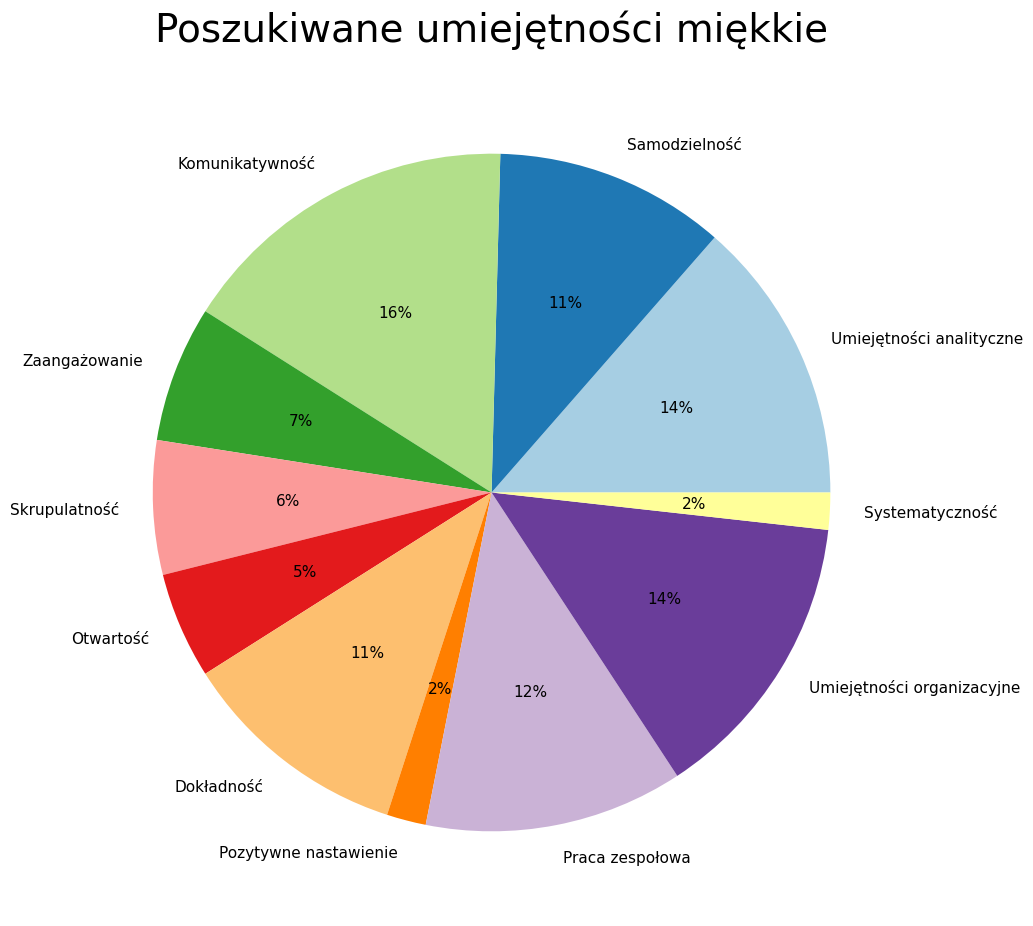

In [13]:
### Wyszukiwanie i wykres umiejętności miękkich


# Lista umiejętności miękkich do wyszukania
umiejetnosci_miekkie = [
    'analityczn', 'samodzieln', 'komunika',
    'zaangażowan', 'skrupulatn', 'otwart', 'dokładn',
    'pozytywn','zespo', 'organizac', 'systematyczn']

# Nazwy umiejętności miękkich do wykresu
labels_miękkie = [
    'Umiejętności analityczne', 'Samodzielność', 'Komunikatywność',
    'Zaangażowanie', 'Skrupulatność', 'Otwartość', 'Dokładność',
    'Pozytywne nastawienie', 'Praca zespołowa', 'Umiejętności organizacyjne', 'Systematyczność']


# Słownik do przechowywania liczby wystąpień każdej umiejętności miękkiej
liczba_umiejetnosci_miekkich = {umiejetnosc: 0 for umiejetnosc in umiejetnosci_miekkie}

# Funkcja licząca wystąpienia umiejętności miękkich w tekście i aktualizująca liczbę wystąpień w słowniku
def policz_umiejetnosci_miekkie(wyrazenie, umiejetnosci_miekkie):
    for umiejetnosc in umiejetnosci_miekkie:
        if umiejetnosc.lower() in wyrazenie.lower():
            liczba_umiejetnosci_miekkich[umiejetnosc] += 1

# Zastosowanie funkcji do kolumny 'Wymagania'
df['Wymagania'].apply(lambda x: policz_umiejetnosci_miekkie(x, umiejetnosci_miekkie))

print("Liczba wystąpień umiejętności miękkich:")
print(liczba_umiejetnosci_miekkich)


colors = plt.cm.Paired(range(len(labels_miękkie)))

# Wykres kołowy
plt.figure(figsize=(11,11))
plt.pie(
    liczba_umiejetnosci_miekkich.values(), 
    labels=labels_miękkie,
    autopct='%1.0f%%',
    textprops={'fontsize':11},
    colors=colors)

plt.title(
    label="Poszukiwane umiejętności miękkie", 
    fontdict={"fontsize":28},
    pad=20,
    loc="center")

# Zapisanie wykresu
plt.savefig('Wykres_umiejętności_miękkie.png', transparent=True)

plt.show()

In [14]:
### Ile ofert zawiera w sobie zakładkę "technologie"


procent = (len(df) - (df['Technologie'].values == '').sum()) / len(df)
print(str(int(procent*100)) + "%")

10%


In [15]:
# Podsumowujące dataframes


umiejętności_miękkie = pd.DataFrame([liczba_umiejetnosci_miekkich]).transpose()
umiejętności_informatyczne = pd.DataFrame([liczba_wystapien]).transpose() #dataframe na bazie poszukiwanych przez nas słów kluczowych z zakresu IT
języki = pd.DataFrame([liczba_umiejetnosci]).transpose()
wszystkie_technologie = pd.DataFrame([technologies_count]).transpose() #dataframe na bazie kolumny "technologie"

# Nazwy kolumn i wierszy
umiejętności_miękkie.columns = ["Liczba"]
umiejętności_miękkie.index = labels_miękkie
umiejętności_informatyczne.columns = ["Liczba"]
języki.columns = ["Liczba"]
wszystkie_technologie.columns = ["Liczba"]

# Sortowanie
umiejętności_miękkie = umiejętności_miękkie.sort_values(by="Liczba", ascending=False)
umiejętności_informatyczne = umiejętności_informatyczne.sort_values(by="Liczba", ascending=False)
języki = języki.sort_values(by="Liczba", ascending=False)
wszystkie_technologie = wszystkie_technologie.sort_values(by="Liczba", ascending=False)


display(df)
display(umiejętności_miękkie)
display(umiejętności_informatyczne)
display(języki)
display(wszystkie_technologie)

Link Technologie  \
0    https://www.pracuj.pl/praca/spring-2024-local-...               
1    https://www.pracuj.pl/praca/smb-ops-summer-int...               
2    https://www.pracuj.pl/praca/mlodszy-analityk-n...               
3    https://www.pracuj.pl/praca/mlodsza-y-ksiegowa...               
4    https://www.pracuj.pl/praca/junior-analyst-f-m...               
..                                                 ...         ...   
413  https://www.pracuj.pl/praca/platny-staz-dzial-...               
414  https://www.pracuj.pl/praca/junior-accountant-...               
415  https://www.pracuj.pl/praca/asystent-asystentk...               
416  https://www.pracuj.pl/praca/mlodszy-ksiegowy-m...               
417  https://www.pracuj.pl/praca/ksiegowy-a-w-dzial...               

                                             Obowiązki  \
0    During the Internship you will be exposed to a...   
1    You will get hands-on experience working with ...   
2    Na stanowisku operacyjnym w LOT REVENUE MANAGE...   
3    przetwarzanie dokumentacji księgowej zgodnie z...   
4    Weryfikacja poprawności danych w systemie CRM,...   
..                                                 ...   
413  Wyszukiwanie i analiza informacji z obszaru po...   
414  Piazzaro, a forward-thinking company based in ...   
415  Asystent będzie współpracował ze Starszym Spec...   
416  Dekretowanie, księgowanie dokumentów (min. zak...   
417  Odpowiedzialność za procesy księgowe w dziale ...   

                                             Wymagania  
0    You are at least third year student of bachelo...  
1    Be in your penultimate year of university (Gra...  
2    Szukamy najlepszych – analityków, strategów, o...  
3    min. 1 rok doświadczenia na podobnym stanowisk...  
4    Wykształcenie wyższe (preferowane kierunki: fi...  
..                                                 ...  
413  Jesteś Studentem IV lub V roku studiów prawnic...  
414  ● Initial experience in a similar role, demons...  
415  Dyplom ukończenia studiów wyższych lub zaawans...  
416  Samodzielność i zaangażowanie, Znajomość podst...  
417  Minimum 2 lata doświadczenia w pracy w dziale ...  

[418 rows x 4 columns]

Liczba
Komunikatywność                149
Umiejętności organizacyjne     127
Umiejętności analityczne       123
Praca zespołowa                112
Samodzielność                  100
...                            ...
Zaangażowanie                   59
Skrupulatność                   58
Otwartość                       46
Pozytywne nastawienie           17
Systematyczność                 16

[11 rows x 1 columns]

Liczba
Excel        235
Office       181
SQL           58
SAP           31
Java          17
...          ...
CSS            1
PHP            1
MatLab         0
Maxima         0
Mulesoft       0

[39 rows x 1 columns]

Liczba
Angielski      387
Niemiecki       33
Francuski       11
Hiszpański       7
Czeski           3
Włoski           3
Ukraiński        2
Norweski         1
Rosyjski         1

Liczba
SQL                     14
Python                   9
JavaScript               8
Jira                     6
Java                     6
...                    ...
inne.                    1
TETAME                   1
TETA HRM                 1
PowerPoint               1
Azure Data Factory       1

[118 rows x 1 columns]